# Clustering

[Danya Merkulov](https://t.me/fminxyz) based on the materials from Mikhail Belyaev and Maxim Panov.

## 🧠 Intuition with k-means
### 🤔 Problem

* In the scatter plot below, we can see three separate groups of data points and we would like to recover them using clustering.
* Think of "discovering" the class labels that we already take for granted in a classification task.
* Even if the groups are obvious in the data, it is hard to find them when the data lives in a high-dimensional space, which we can't visualize in a single histogram or scatterplot.

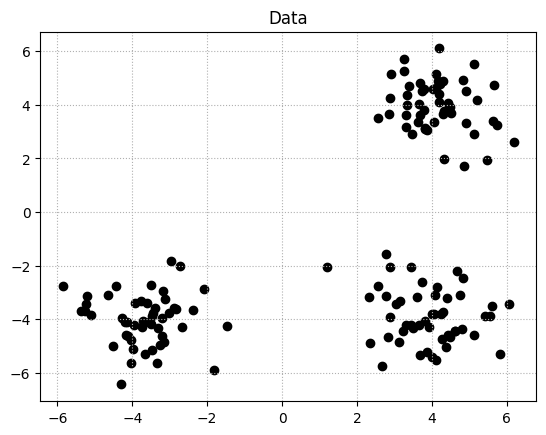

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn.cluster import KMeans
from matplotlib.animation import FuncAnimation
from IPython import display

# Generating random data for the illustration
np.random.seed(1)
points1 = np.random.randn(50, 2) + [4, 4]
points2 = np.random.randn(50, 2) + [-4, -4]
points3 = np.random.randn(50, 2) + [4, -4]
data = np.vstack([points1, points2, points3])

fig, ax = plt.subplots()
plt.title("Data")
scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
centroids_plot, = ax.plot([], [], markeredgewidth=2, color='yellow', ls='', marker='*')
ax.grid(linestyle=':')
plt.show()

### 👨‍🏫 k-means algorithm

* Now we will use one of the simplest clustering algorithms, K-means.
* This is an iterative algorithm which searches for three cluster centers such that the distance from each point to its cluster is minimized.
* The standard implementation of K-means uses the Euclidean distance.

**Question:** what would you expect the output to look like??

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.metrics import accuracy_score
from itertools import permutations

# Generating random data for the illustration
np.random.seed(1)
points1 = np.random.randn(50, 2) + [4, 4]
points2 = np.random.randn(50, 2) + [-4, -4]
points3 = np.random.randn(50, 2) + [4, -4]
data = np.vstack([points1, points2, points3])
true_labels = np.array([0]*50 + [1]*50 + [2]*50)

fig, ax = plt.subplots()
ax.grid(linestyle=':')

def compute_accuracy(true_labels, kmeans_labels):
    perm = permutations([0, 1, 2])
    max_accuracy = -1
    for p in perm:
        temp_labels = np.array([p[i] for i in kmeans_labels])
        accuracy = accuracy_score(true_labels, temp_labels)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
    return max_accuracy

# Initialize centroids
def initialize_centroids(points, k):
    return points[np.random.choice(points.shape[0], size=k, replace=False)]

# Closest centroid for each point
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update the centroid locations
def update_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis=0) for k in range(centroids.shape[0])])

def voronoi_polygons(centroids, ax):
    xx, yy = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 500),
                         np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500))
    Z = np.argmin(((xx - centroids[:, 0][:, np.newaxis, np.newaxis]) ** 2 +
                   (yy - centroids[:, 1][:, np.newaxis, np.newaxis]) ** 2), axis=0)
    return Z

def animate(i):
    global data, centroids
    ax.clear()
    ax.grid(linestyle=':')
    
    if i == 0:
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.set_title("Data")
    elif i == 1:
        centroids = initialize_centroids(data, 3)
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c=['red', 'green', 'blue'], marker='*')
        ax.set_title("Centroid initialization")
    elif i % 2 == 0:
        closest = closest_centroid(data, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title(f"Assigning points | Accuracy: {compute_accuracy(true_labels, closest)*100:.2f}%")
    else:
        closest = closest_centroid(data, centroids)
        centroids = update_centroids(data, closest, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title("Updating centroids")
    
    return scatter,

ani = FuncAnimation(fig, animate, frames=20, interval=2000, blit=True)
plt.close()
html = display.HTML(ani.to_html5_video())
display.display(html)


**Algorithm**

The $k$-means algorithm is a popular clustering method used to partition $n$ data points into $k$ clusters. Each data point belongs to the cluster with the closest mean.

1. **Initialization**: Randomly select $k$ data points (or seed them in some other manner) to serve as the initial centroids.

2. **Assignment**: Assign each data point to the nearest centroid. The distance is typically computed using the Euclidean distance, though other metrics can be used. Mathematically, assign each data point $x_i$ to the nearest centroid $c_j$ using the formula:
    $$
    s(i) = \text{argmin}_{j} \left\| x_i - c_j \right\|^2
    $$
    where $s(i)$ is the cluster to which data point $x_i$ is assigned.

3. **Update**: Recompute the centroid of each cluster as the mean of all points currently assigned to that cluster. For each cluster $j$:
    $$
    c_j = \frac{1}{\left| S(j) \right|} \sum_{i \in S(j)} x_i
    $$
    where $S(j)$ is the set of data points assigned to cluster $j$.

4. **Convergence**: Repeat steps 2 and 3 until the centroids no longer change significantly or some other stopping criteria is met.

**Objective Function:**

The $k$-means algorithm aims to minimize the within-cluster sum of squares (WCSS), given by:
$$
J = \sum_{j=1}^{k} \sum_{i \in S(j)} \left\| x_i - c_j \right\|^2
$$
Where:
- $J$ is the objective function value (WCSS).
- $k$ is the number of clusters.
- $x_i$ is a data point.
- $c_j$ is the centroid of cluster $j$.

The goal of the $k$-means algorithm is to find the set of centroids $\{c_1, c_2, ..., c_k\}$ that minimize $J$.

**Notes:**

- The $k$-means algorithm does not guarantee a global optimum solution. The final result might depend on the initial centroids.
- To improve the chances of finding a global optimum, the algorithm can be run multiple times with different initializations and the best result (i.e., the one with the lowest WCSS) can be selected.


### 🤪 What could possibly go wrong?

#### 🎲 Randomness

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.metrics import accuracy_score
from itertools import permutations

# Generating random data for the illustration
np.random.seed(1)
points1 = np.random.randn(50, 2) + [4, 4]
points2 = np.random.randn(50, 2) + [-4, -4]
points3 = np.random.randn(50, 2) + [4, -4]
data = np.vstack([points1, points2, points3])
true_labels = np.array([0]*50 + [1]*50 + [2]*50)

fig, ax = plt.subplots()
ax.grid(linestyle=':')

def compute_accuracy(true_labels, kmeans_labels):
    perm = permutations([0, 1, 2])
    max_accuracy = -1
    for p in perm:
        temp_labels = np.array([p[i] for i in kmeans_labels])
        accuracy = accuracy_score(true_labels, temp_labels)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
    return max_accuracy

# Initialize centroids
def initialize_centroids(points, k):
    return points[np.random.choice(points.shape[0], size=k, replace=False)]

# Closest centroid for each point
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update the centroid locations
def update_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis=0) for k in range(centroids.shape[0])])

def voronoi_polygons(centroids, ax):
    xx, yy = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 500),
                         np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500))
    Z = np.argmin(((xx - centroids[:, 0][:, np.newaxis, np.newaxis]) ** 2 +
                   (yy - centroids[:, 1][:, np.newaxis, np.newaxis]) ** 2), axis=0)
    return Z

def animate(i):
    global data, centroids
    ax.clear()
    ax.grid(linestyle=':')
    
    if i == 0:
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.set_title("Data")
    elif i == 1:
        centroids = initialize_centroids(data, 3)
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c=['red', 'green', 'blue'], marker='*')
        ax.set_title("Centroid initialization")
    elif i % 2 == 0:
        closest = closest_centroid(data, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title(f"Assigning points | Accuracy: {compute_accuracy(true_labels, closest)*100:.2f}%")
    else:
        closest = closest_centroid(data, centroids)
        centroids = update_centroids(data, closest, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title("Updating centroids")
    
    return scatter,

ani = FuncAnimation(fig, animate, frames=20, interval=2000, blit=True)
plt.close()
html = display.HTML(ani.to_html5_video())
display.display(html)


**Question** How do you think this could be possibly fixed?

#### 🤷‍♂️ The number of clusters

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.metrics import accuracy_score
from itertools import permutations

K = 20

# Generating random data for the illustration
np.random.seed(1)
points1 = np.random.randn(50, 2) + [4, 4]
points2 = np.random.randn(50, 2) + [-4, -4]
points3 = np.random.randn(50, 2) + [4, -4]
data = np.vstack([points1, points2, points3])
true_labels = np.array([0]*50 + [1]*50 + [2]*50)

fig, ax = plt.subplots()
ax.grid(linestyle=':')

def compute_accuracy(true_labels, kmeans_labels):
    perm = permutations([0, 1, 2])
    max_accuracy = -1
    for p in perm:
        temp_labels = np.array([p[i] for i in kmeans_labels])
        accuracy = accuracy_score(true_labels, temp_labels)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
    return max_accuracy

# Initialize centroids
def initialize_centroids(points, k):
    return points[np.random.choice(points.shape[0], size=k, replace=False)]

# Closest centroid for each point
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update the centroid locations
def update_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis=0) for k in range(centroids.shape[0])])

def voronoi_polygons(centroids, ax):
    xx, yy = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 500),
                         np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500))
    Z = np.argmin(((xx - centroids[:, 0][:, np.newaxis, np.newaxis]) ** 2 +
                   (yy - centroids[:, 1][:, np.newaxis, np.newaxis]) ** 2), axis=0)
    return Z

def animate(i):
    global data, centroids
    ax.clear()
    ax.grid(linestyle=':')
    
    if i == 0:
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.set_title("Data")
    elif i == 1:
        centroids = initialize_centroids(data, k=K)
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='*')
        ax.set_title("Centroid initialization")
    elif i % 2 == 0:
        closest = closest_centroid(data, centroids)
        
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title(f"Assigning points")
    else:
        closest = closest_centroid(data, centroids)
        centroids = update_centroids(data, closest, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title("Updating centroids")
    
    return scatter,

ani = FuncAnimation(fig, animate, frames=20, interval=2000, blit=True)
plt.close()
html = display.HTML(ani.to_html5_video())
display.display(html)


**Question** How do you think this could be possibly fixed?

##### 💪 Elbow method
* The Elbow method is a "rule-of-thumb" approach to finding the optimal number of clusters.
* Here, we look at the cluster variance for different values of k:

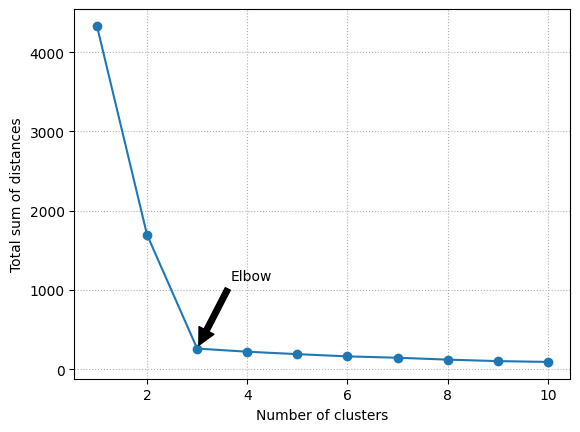

In [76]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                random_state=1, 
                n_init=10)
    km.fit(data)
    distortions.append(km.inertia_)

# Plot the distortions
plt.plot(range(1, 11), distortions, "o-")
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of distances')
plt.grid(linestyle=":")

# Annotate the point at k=3 with an arrow
k = 3
plt.annotate('Elbow', xy=(k, distortions[k-1]), xytext=(k+1.5, distortions[k-1]+(max(distortions)*0.2)),
             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')
plt.show()


Then, we pick the value that resembles the "pit of an elbow." As we can see, this would be k=3 in this case, which makes sense given our visual expection of the dataset previously.

**Clustering comes with assumptions**:
* A clustering algorithm finds clusters by making assumptions with samples should be grouped together.
* Each algorithm makes different assumptions and the quality and interpretability of your results will depend on whether the assumptions are satisfied for your goal.
* For K-means clustering, the model is that all clusters have equal, spherical variance.

**In general, there is no guarantee that structure found by a clustering algorithm has anything to do with what you were interested in**.


#### ◾️◼️⬛️ Different variance

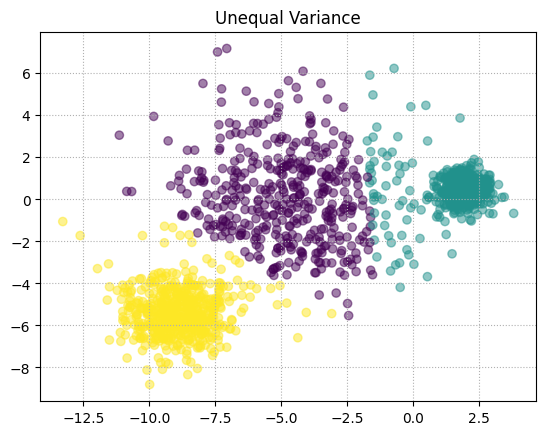

In [80]:
from sklearn.datasets import make_blobs
n_samples = 1500
random_state = 170

X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)

kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=10)

labels = kmeans.fit_predict(X_varied)


plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels, alpha=.5)
plt.title("Unequal Variance")
plt.grid(linestyle=":")
plt.show()

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from sklearn.metrics import accuracy_score
from itertools import permutations

# Generating random data for the illustration
np.random.seed(1)
points1 = 1e-1*np.random.randn(50, 2) + [1.1, 1.1]
points2 = np.random.randn(50, 2) + [-1.1, -1.1]
points3 = 6e-1*np.random.randn(50, 2) + [1.1, -1.1]
data = np.vstack([points1, points2, points3])
true_labels = np.array([0]*50 + [1]*50 + [2]*50)

fig, ax = plt.subplots()
ax.grid(linestyle=':')

def compute_accuracy(true_labels, kmeans_labels):
    perm = permutations([0, 1, 2])
    max_accuracy = -1
    for p in perm:
        temp_labels = np.array([p[i] for i in kmeans_labels])
        accuracy = accuracy_score(true_labels, temp_labels)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
    return max_accuracy

# Initialize centroids
def initialize_centroids(points, k):
    return points[np.random.choice(points.shape[0], size=k, replace=False)]

# Closest centroid for each point
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update the centroid locations
def update_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis=0) for k in range(centroids.shape[0])])

def voronoi_polygons(centroids, ax):
    xx, yy = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 500),
                         np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 500))
    Z = np.argmin(((xx - centroids[:, 0][:, np.newaxis, np.newaxis]) ** 2 +
                   (yy - centroids[:, 1][:, np.newaxis, np.newaxis]) ** 2), axis=0)
    return Z

def animate(i):
    global data, centroids
    ax.clear()
    ax.grid(linestyle=':')
    
    if i == 0:
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.set_title("Data")
    elif i == 1:
        centroids = initialize_centroids(data, 3)
        scatter = ax.scatter(data[:, 0], data[:, 1], c='black')
        ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c=['red', 'green', 'blue'], marker='*')
        ax.set_title("Centroid initialization")
    elif i % 2 == 0:
        closest = closest_centroid(data, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title(f"Assigning points | Accuracy: {compute_accuracy(true_labels, closest)*100:.2f}%")
    else:
        closest = closest_centroid(data, centroids)
        centroids = update_centroids(data, closest, centroids)
        scatter = ax.scatter(data[:, 0], data[:, 1], c=closest, cmap='rainbow')
        Z = voronoi_polygons(centroids, ax)
        ax.imshow(Z, interpolation='nearest',
            extent=(ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]),
            aspect='auto', origin='lower', alpha=0.3, cmap='rainbow')
        for idx, centroid in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], markersize=10, color=plt.cm.rainbow(idx/2.5), markeredgecolor='black', ls='', marker='*')
        ax.set_title("Updating centroids")
    
    return scatter,

ani = FuncAnimation(fig, animate, frames=20, interval=2000, blit=True)
plt.close()
html = display.HTML(ani.to_html5_video())
display.display(html)


#### 🐣/🐔 Unevenly sized blobs

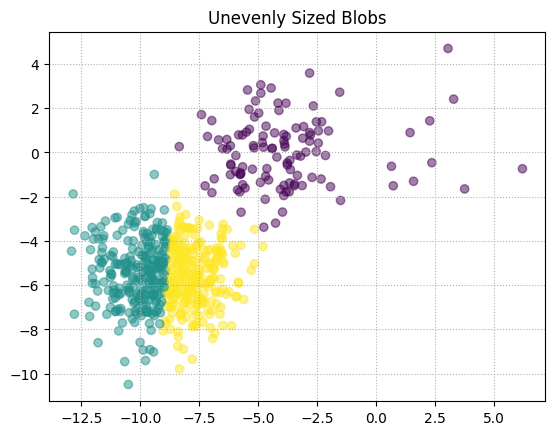

In [99]:
from sklearn.datasets import make_blobs
n_samples = 1500
random_state = 170

X, y = make_blobs(n_samples=n_samples,
                  cluster_std=[1.5, 1.5, 1.5],
                  random_state=random_state)
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))

kmeans = KMeans(n_clusters=3, random_state=random_state,
                n_init=10)

labels = kmeans.fit_predict(X_filtered)

plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=labels, alpha=0.5)
plt.title("Unevenly Sized Blobs")
plt.grid(linestyle=":")
plt.show()

#### ⬬ Anisotropic data

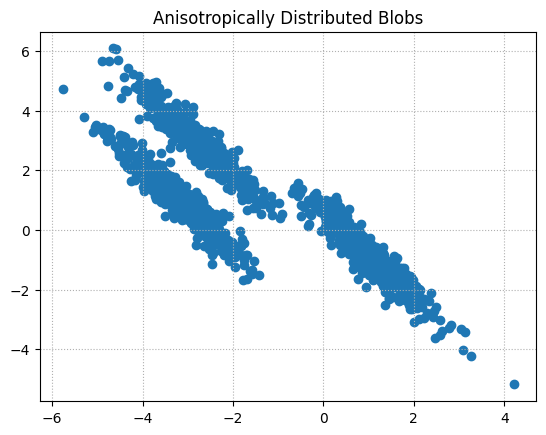

In [109]:
n_samples = 1500
random_state = 170

X, y = make_blobs(n_samples=n_samples, cluster_std=[1.0, 1.0, 1.0], random_state=random_state)

transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

plt.title("Anisotropically Distributed Blobs")
plt.grid(linestyle=":")
plt.scatter(X_aniso[:, 0], X_aniso[:, 1])
plt.show()

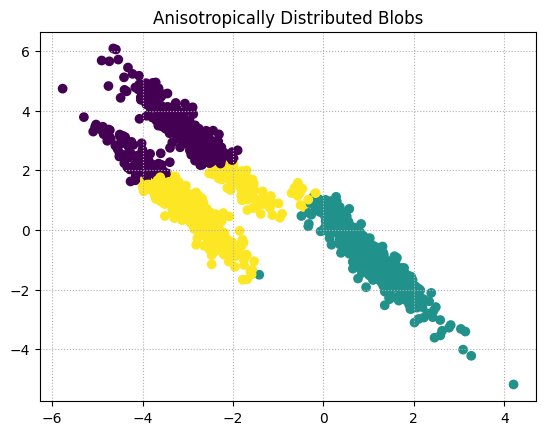

In [110]:
kmeans = KMeans(n_clusters=3, random_state=random_state,n_init=10)

labels = kmeans.fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=labels)
plt.title("Anisotropically Distributed Blobs")
plt.grid(linestyle=":")
plt.show()

##### Gaussian Mixture could solve it

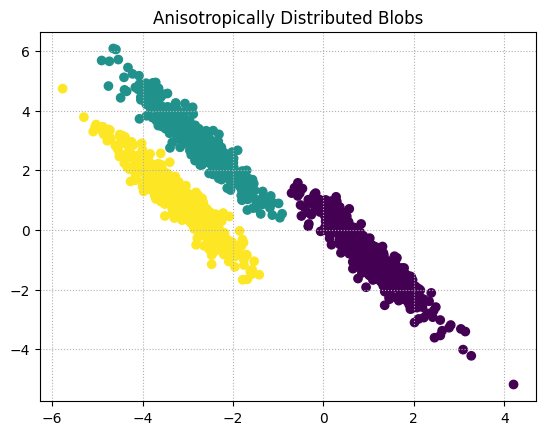

In [111]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type='full', 
                      random_state=random_state)

gmm.fit(X_aniso)

y_pred = gmm.predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropically Distributed Blobs")
plt.grid(linestyle=":")
plt.show()

### Notable Clustering Routines
The following are several well-known clustering algorithms. 

- `sklearn.cluster.KMeans`: <br/>
    The simplest, yet effective clustering algorithm. Needs to be provided with the
    number of clusters in advance, and assumes that the data is normalized as input
    (but use a PCA model as preprocessor).
- `sklearn.cluster.MeanShift`: <br/>
    Can find better looking clusters than KMeans but is not scalable to high number of samples.
- `sklearn.cluster.DBSCAN`: <br/>
    Can detect irregularly shaped clusters based on density, i.e. sparse regions in
    the input space are likely to become inter-cluster boundaries. Can also detect
    outliers (samples that are not part of a cluster).
- `sklearn.cluster.AffinityPropagation`: <br/>
    Clustering algorithm based on message passing between data points.
- `sklearn.cluster.SpectralClustering`: <br/>
    KMeans applied to a projection of the normalized graph Laplacian: finds
    normalized graph cuts if the affinity matrix is interpreted as an adjacency matrix of a graph.
- `sklearn.cluster.Ward`: <br/>
    Ward implements hierarchical clustering based on the Ward algorithm,
    a variance-minimizing approach. At each step, it minimizes the sum of
    squared differences within all clusters (inertia criterion).

Of these, Ward, SpectralClustering, DBSCAN and Affinity propagation can also work with precomputed similarity matrices.

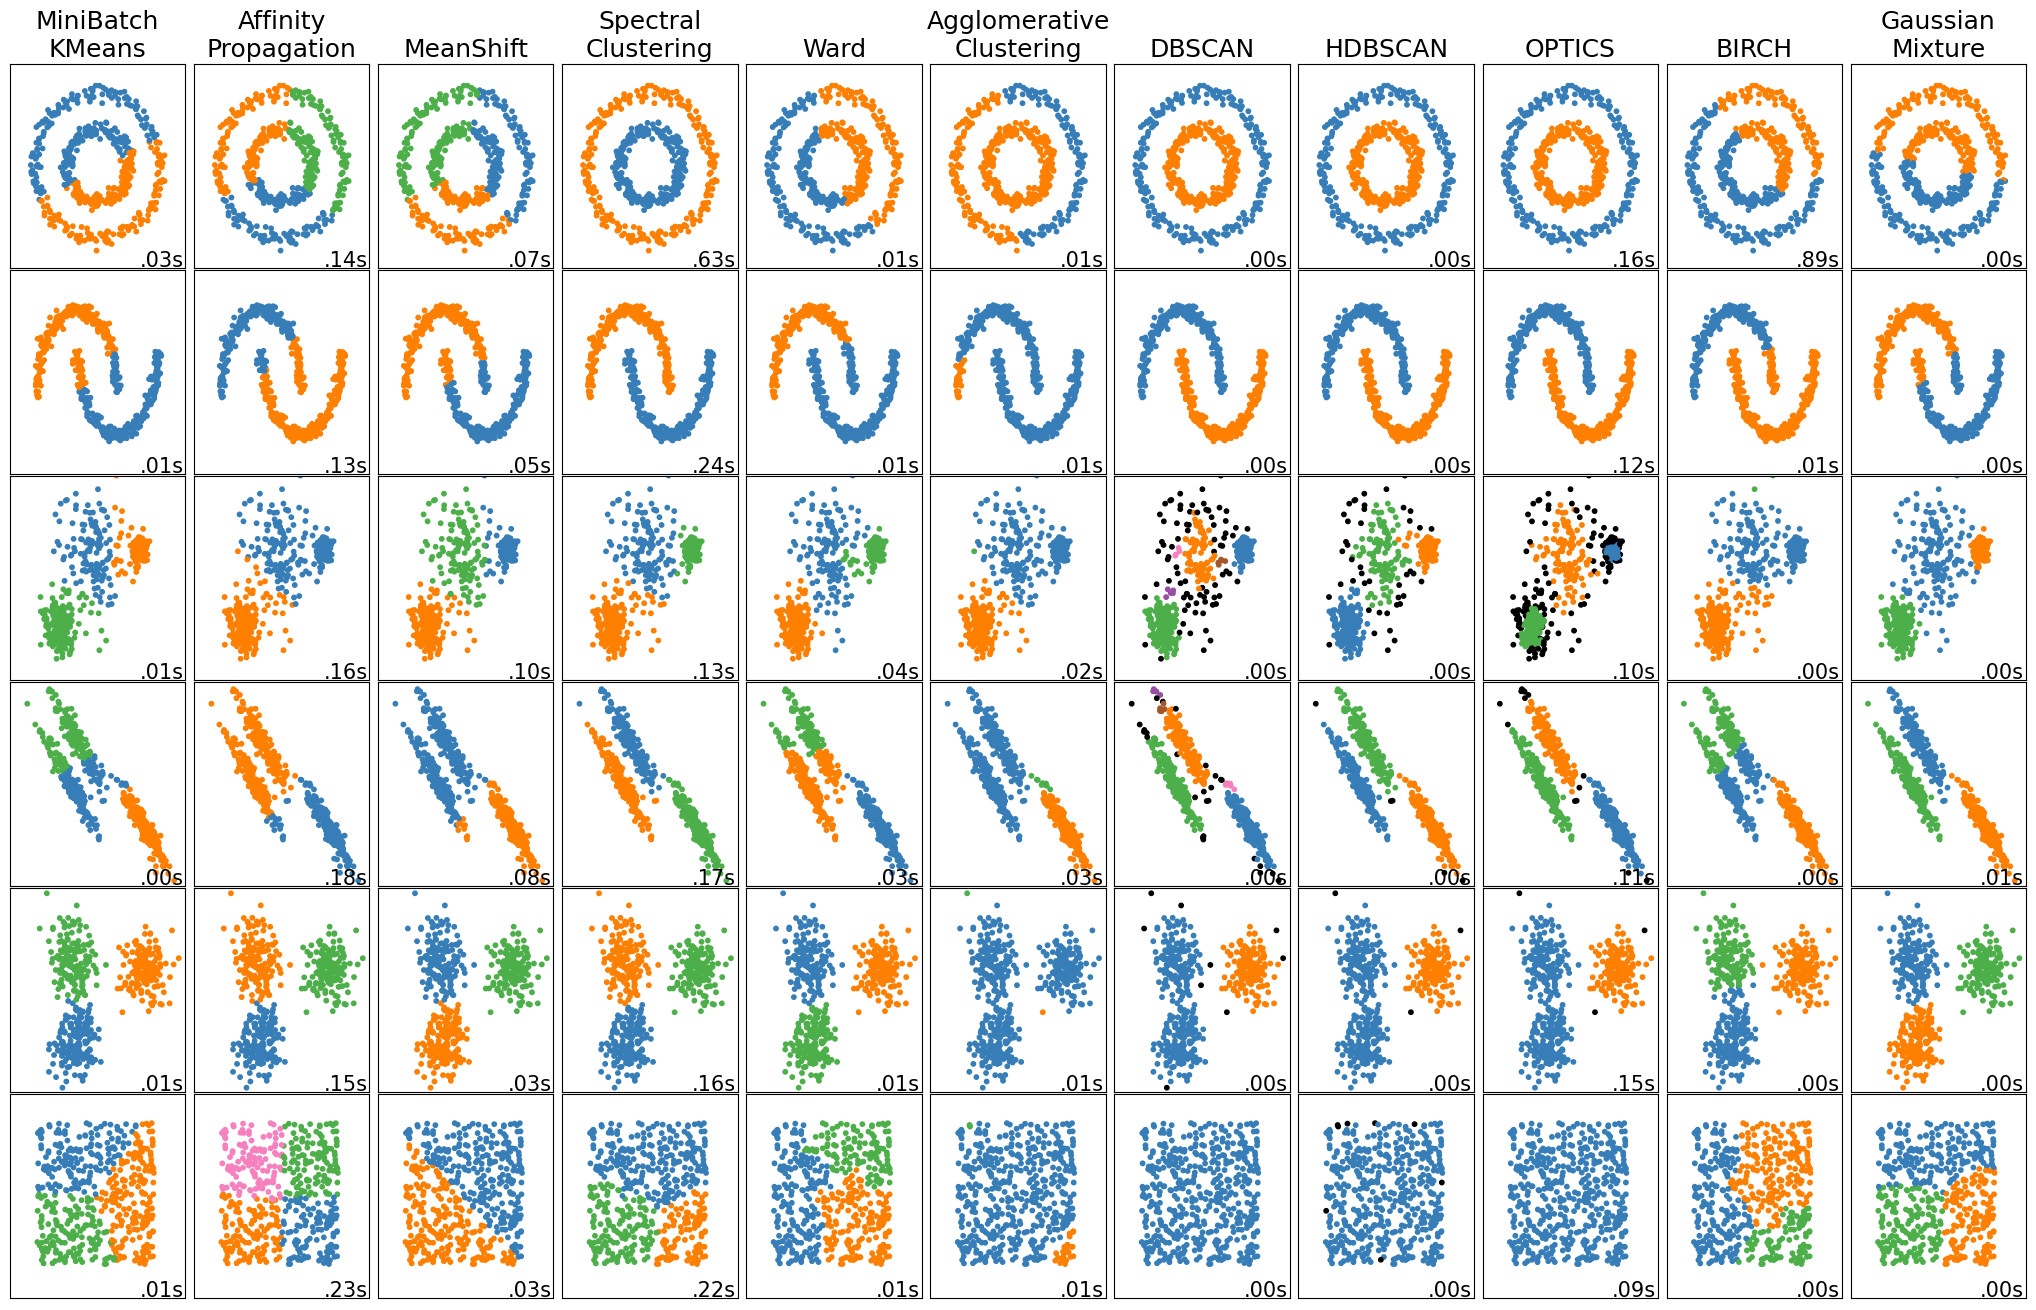

In [112]:
# Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

[💎 Extremely good visualization of k-means clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

## 🏋️‍♂️ Exercise: cluster digits

* Perform K-means clustering on the digits data, searching for ten clusters.
* Visualize the cluster centers as images (i.e. reshape each to 8x8 and use ``plt.imshow``)
* Do the clusters seem to be correlated with particular digits?
* What is the ``adjusted_rand_score``?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import adjusted_rand_score

# Load the MNIST dataset
mnist = fetch_openml('mnist_784',
                     parser="auto")
X = mnist.data / 255.0  # Normalize data to [0, 1]
y = mnist.target.astype(int)  # Convert target values to integers

# Apply K-means clustering
n_clusters = 10

### 🐱🐱🐱 YOUR CODE HERE 🐱🐱🐱
kmeans = None

# Visualize the cluster centers as images
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
axes = axes.ravel()

for i, center in enumerate(kmeans.cluster_centers_):
    axes[i].imshow(center.reshape(28, 28), cmap=plt.cm.gray)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()3

# Do the clusters seem to be correlated with particular digits?
# Let's compute the most common label in each cluster
labels = np.zeros_like(kmeans.labels_)
for i in range(n_clusters):
    mask = (kmeans.labels_ == i)
    labels[mask] = np.bincount(y[mask]).argmax()

# Calculate the adjusted_rand_score
### 🐱🐱🐱 YOUR CODE HERE 🐱🐱🐱
score = None
print(f"Adjusted Rand Score: {score:.4f}")

Try the light version of MNIST (load_digits from sklearn)

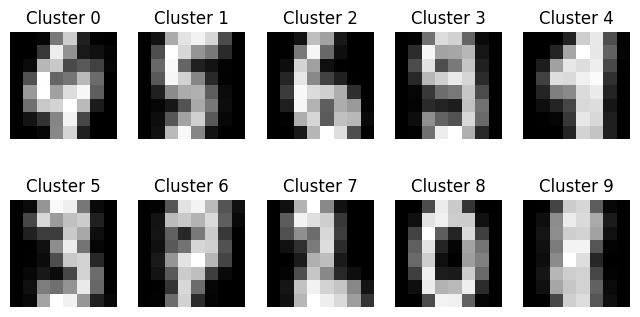

0.6649258693926379


In [132]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
digits.data.shape

### 🐱🐱🐱 YOUR CODE HERE 🐱🐱🐱
kmeans = None
clusters = kmeans.fit_predict(digits.data)

# Visualize the cluster centers as images
fig, axes = plt.subplots(2, 5, figsize=(8, 4))
axes = axes.ravel()

for i, center in enumerate(kmeans.cluster_centers_):
    axes[i].imshow(center.reshape(8, 8), cmap=plt.cm.gray)
    axes[i].axis('off')
    axes[i].set_title(f'Cluster {i}')

plt.show()

### 🐱🐱🐱 YOUR CODE HERE 🐱🐱🐱
score = None
print(f"Adjusted Rand Score: {score:.4f}")

## 👑 Hierarchical Clustering

* One nice feature of hierarchical clustering is that we can visualize the results as a dendrogram, a hierarchical tree.
* Using the visualization, we can then decide how "deep" we want to cluster the dataset by setting a "depth" threshold
* Or in other words, we don't need to make a decision about the number of clusters upfront.

### ➗ Agglomerative and divisive hierarchical clustering

* Furthermore, we can distinguish between 2 main approaches to hierarchical clustering: Divisive clustering and agglomerative clustering.
* In agglomerative clustering, we start with a single sample from our dataset and iteratively merge it with other samples to form clusters - we can see it as a bottom-up approach for building the clustering dendrogram.  
* In divisive clustering, however, we start with the whole dataset as one cluster, and we iteratively split it into smaller subclusters - a top-down approach.  

In this notebook, we will use **agglomerative** clustering.

### Single and complete linkage

* Now, the next question is how we measure the similarity between samples.
* One approach is the familiar Euclidean distance metric that we already used via the K-Means algorithm. 
* As a refresher, the distance between 2 m-dimensional vectors $\mathbf{p}$ and $\mathbf{q}$ can be computed as:

\begin{align} \mathrm{d}(\mathbf{q},\mathbf{p}) & = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_m-p_m)^2} \\[8pt]
& = \sqrt{\sum_{j=1}^m (q_j-p_j)^2} = \|\mathbf{q} - \mathbf{p}\|_2\end{align}	

* However, that's the distance between 2 samples.
* Now, how do we compute the similarity between subclusters of samples?
* I.e., our goal is to iteratively merge the most similar pairs of clusters until only one big cluster remains.
* There are many different approaches to this, for example single and complete linkage.

* In single linkage, we take the pair of the most similar samples (based on the Euclidean distance, for example) in each cluster, and merge the two clusters which have the most similar 2 members into one new, bigger cluster.
* In complete linkage, we compare the pairs of the two most dissimilar members of each cluster with each other, and we merge the 2 clusters where the distance between its 2 most dissimilar members is smallest.

![](linkage.svg)

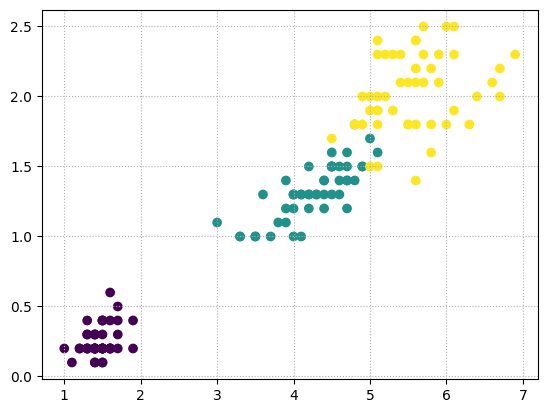

In [137]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
n_samples, n_features = X.shape

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.grid(linestyle=":")
plt.show()

In [138]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [139]:
clusters = linkage(X, metric='euclidean', method='complete')

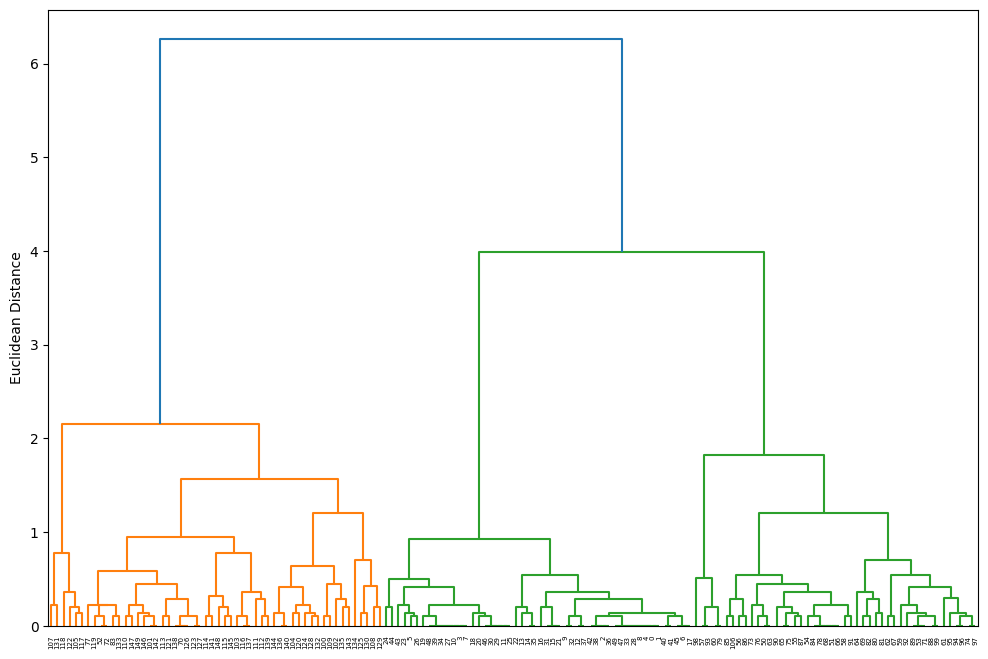

In [146]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
dendr = dendrogram(clusters, ax=ax)
plt.ylabel('Euclidean Distance')
plt.show()

In [141]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean',
                             linkage='complete')

prediction = ac.fit_predict(X)
print('Cluster labels: %s\n' % prediction)

Cluster labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]



/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


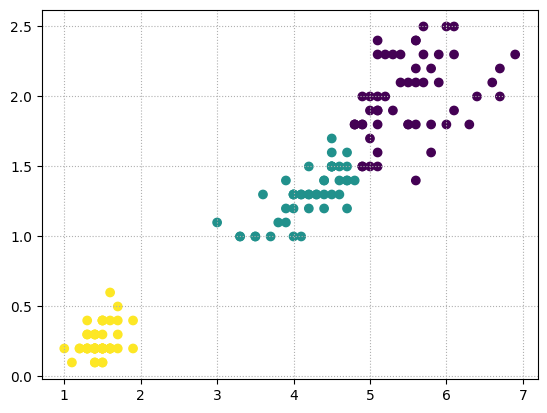

In [143]:
plt.scatter(X[:, 0], X[:, 1], c=prediction)
plt.grid(linestyle=":")
plt.show()

## 💎 Density-based Clustering - DBSCAN

* Another useful approach to clustering is *Density-based Spatial Clustering of Applications with Noise* (DBSCAN).
* In essence, we can think of DBSCAN as an algorithm that divides the dataset into subgroup based on dense regions of points.

In DBSCAN, we distinguish between 3 different "points":

- Core points: A core point is a point that has at least a minimum number of other points (MinPts) in its radius epsilon.
- Border points: A border point is a point that is not a core point, since it doesn't have enough MinPts in its neighborhood, but lies within the radius epsilon of a core point.
- Noise points: All other points that are neither core points nor border points.

![](dbscan.png)

A nice feature about DBSCAN is that we don't have to specify a number of clusters upfront. However, it requires the setting of additional hyperparameters such as the value for MinPts and the radius epsilon.

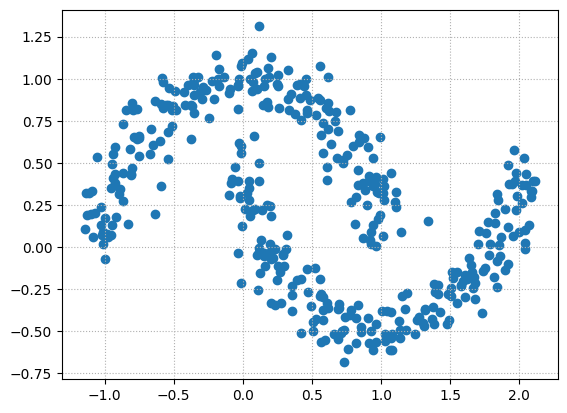

In [35]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=400, noise=0.1, random_state=1)
plt.scatter(X[:,0], X[:,1])
plt.grid(linestyle=":")
plt.show()

[ 0  1  0  0  1  0  1  0  1  0  1  0  1  0  0  0  0  1  1  0  1  0  0  0
  1  1  0  0  0  0  1  1  1  0  1  1  1  1  0  1  0  0  1  1  0  1  0  0
  0  0  1  0  0  1  0  0  0  1  0  0  1  1  0  0  0  0  1  0  0  0  0  1
  0  0  1  0  1  1  1  0  1  1  0 -1  1  1  0  0  0  1  1  0  0  0  1  0
  0  0  0  1  1  0  1  1  1  0  1  0  0  0  1  0  1  0  1  1  0  0  1  0
  1  1  0  0  0  1  1  1  0  0  0  0  0  0  0  0  1  1  1  0  1  1  1  1
  1  1  1  1  1  1  0  1  1  1  0  0  1  1  1  0  1  0  0  1  0  1  1  0
  1  0  0  0  0  0  1  1  0  1  1  1  1  0  1  0  1  1  1  1  0  1  0  0
  0  1  0  1  1  0  1  1  0  1  0  0  0  1  1  1  0  1  0  1  0  0  0  1
  0  1  0  1  1  1  1  0  1  0  0  0  0  0  0  1  0  1  0  1  1 -1  0  0
  1  1  1  1  1  1  1  0  1  1  0  1  1  0  1  0  1  0  0  0  0  0  0  1
  0  0  0  1  1  1  1  0 -1  0  1  1  1  1  1  0  1  0  1  0  1  1  1  1
  1  0  1  0  1  0  1  0  0  1  0  1  0  1  0  1  0  1  0  0  1  0  1  1
  0  0  0  1  1  0  0  1  1  0  0  1  0  1  0  0  0

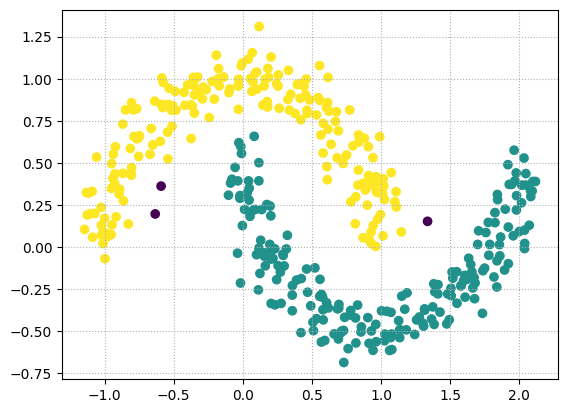

In [36]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
labels = db.fit_predict(X)
print(labels)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.grid(linestyle=":")
plt.show()

[💎 Extremely good visualization of DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

### 🏋️‍♂️ Exercise

* Using the following toy datasets, two concentric circles, experiment with the three different clustering algorithms that we used so far `KMeans`, `AgglomerativeClustering`, and `DBSCAN`.
* Which clustering algorithms reproduces or discovers the hidden structure (pretending we don't know `y`) best?
* Can you explain why this particular algorithm is a good choice while the other 2 "fail"?

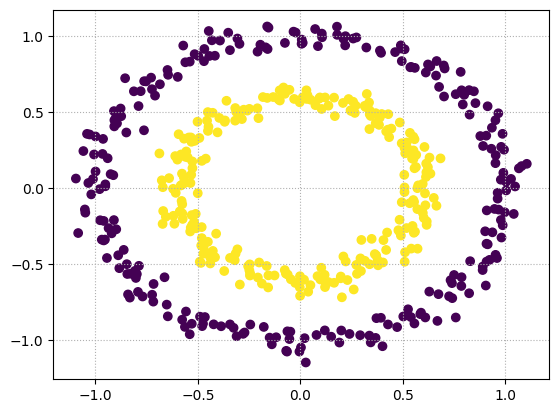

In [154]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, factor=.6, noise=.05)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.grid(linestyle=":")
plt.show()

In [ ]:
### 🐱🐱🐱 YOUR CODE HERE 🐱🐱🐱

## 💅 Community detection

### 🥋 Karate club

In [171]:
!pip install -q community node2vec python-louvain


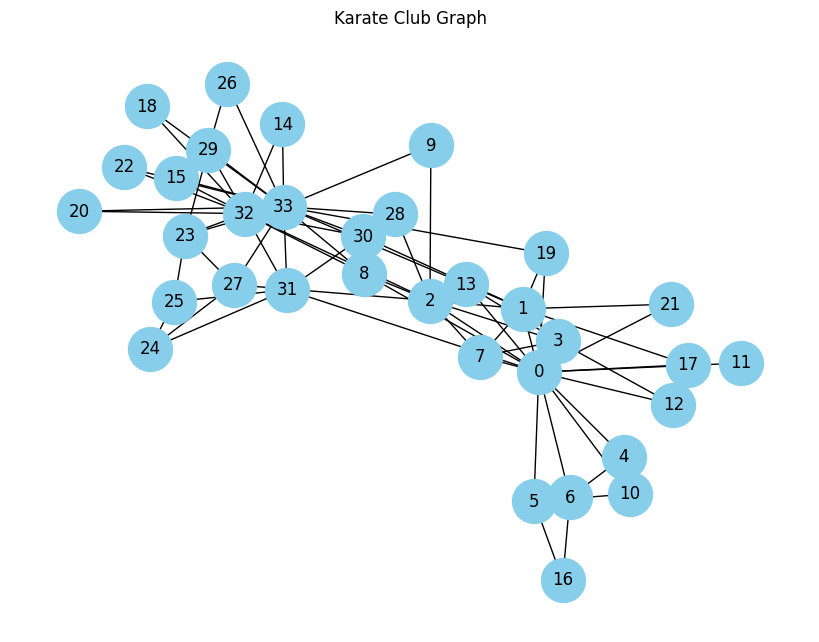

In [170]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club graph
G = nx.karate_club_graph()

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color="skyblue", node_size=1000)
plt.title("Karate Club Graph")
plt.show()


In [179]:
print(nx.adjacency_matrix(G))

  (0, 1)	4
  (0, 2)	5
  (0, 3)	3
  (0, 4)	3
  (0, 5)	3
  (0, 6)	3
  (0, 7)	2
  (0, 8)	2
  (0, 10)	2
  (0, 11)	3
  (0, 12)	1
  (0, 13)	3
  (0, 17)	2
  (0, 19)	2
  (0, 21)	2
  (0, 31)	2
  (1, 0)	4
  (1, 2)	6
  (1, 3)	3
  (1, 7)	4
  (1, 13)	5
  (1, 17)	1
  (1, 19)	2
  (1, 21)	2
  (1, 30)	2
  :	:
  (32, 18)	1
  (32, 20)	3
  (32, 22)	2
  (32, 23)	5
  (32, 29)	4
  (32, 30)	3
  (32, 31)	4
  (32, 33)	5
  (33, 8)	4
  (33, 9)	2
  (33, 13)	3
  (33, 14)	2
  (33, 15)	4
  (33, 18)	2
  (33, 19)	1
  (33, 20)	1
  (33, 22)	3
  (33, 23)	4
  (33, 26)	2
  (33, 27)	4
  (33, 28)	2
  (33, 29)	2
  (33, 30)	3
  (33, 31)	4
  (33, 32)	5


In [172]:
from node2vec import Node2Vec

# Generate embeddings using Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Get embeddings for all nodes
embeddings = [model.wv[str(node)] for node in G.nodes()]

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 506.18it/s]


/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


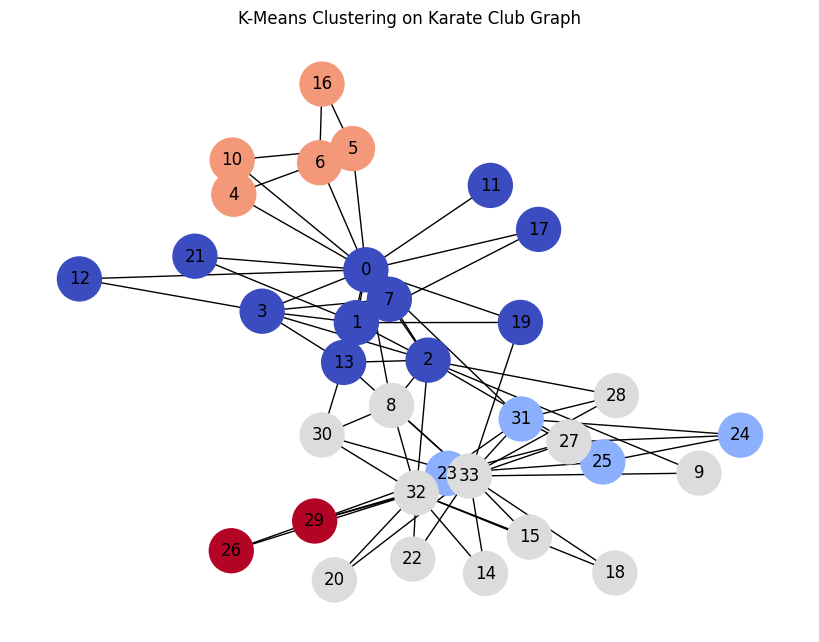

In [180]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans_clusters = kmeans.fit_predict(embeddings)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=kmeans_clusters, cmap="coolwarm", node_size=1000)
plt.title("K-Means Clustering on Karate Club Graph")
plt.show()


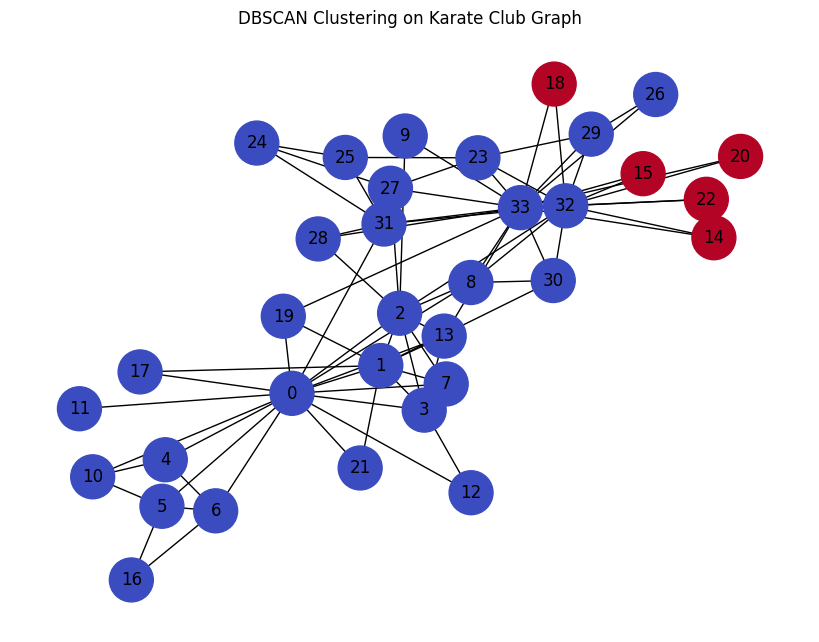

In [175]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(embeddings)

# Visualize DBSCAN clusters
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=dbscan_clusters, cmap="coolwarm", node_size=1000)
plt.title("DBSCAN Clustering on Karate Club Graph")
plt.show()


### 🥺📘 Facebook ego networks

In [25]:
import networkx as nx

import requests
import gzip
import shutil
from matplotlib import pyplot as plt

# Download the dataset
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
response = requests.get(url, stream=True)
with open("facebook_combined.txt.gz", "wb") as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

# Unzip the dataset
with gzip.open("facebook_combined.txt.gz", 'rb') as f_in:
    with open("facebook_combined.txt", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


# Load the Facebook graph
path_to_dataset = "facebook_combined.txt"
G = nx.read_edgelist(path_to_dataset)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 4039
Number of edges: 88234


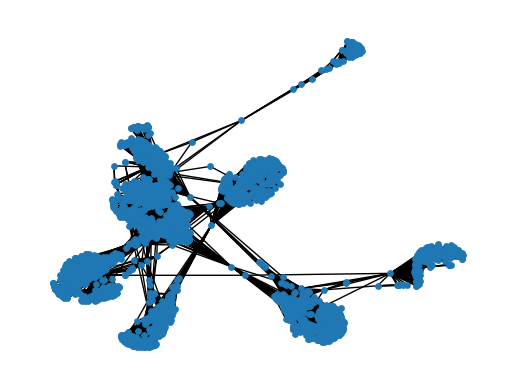

In [26]:
#Create network layout for visualizations

spring_pos = nx.layout.spring_layout(G)

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, with_labels=False, node_size=15)

In [30]:
import community as community_louvain

parts = community_louvain.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

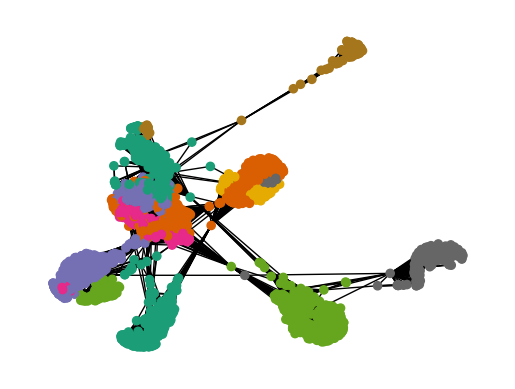

In [31]:
#drawing

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Dark2"),
                 node_color=values, node_size=35, with_labels=False)

In [33]:
print(community_louvain.modularity(parts, G))

0.8348452461385243


In [12]:
from node2vec import Node2Vec

# Generate embeddings using Node2Vec
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=50, workers=4)
model = node2vec.fit(window=10, min_count=1)

# Get embeddings for all nodes
embeddings = [model.wv[node] for node in G.nodes()]


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)  # assuming 10 clusters for demonstration
kmeans_clusters = kmeans.fit_predict(embeddings)


/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(embeddings)


/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_24364/271705878.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(G.nodes(), 1000)  # sample 1000 nodes


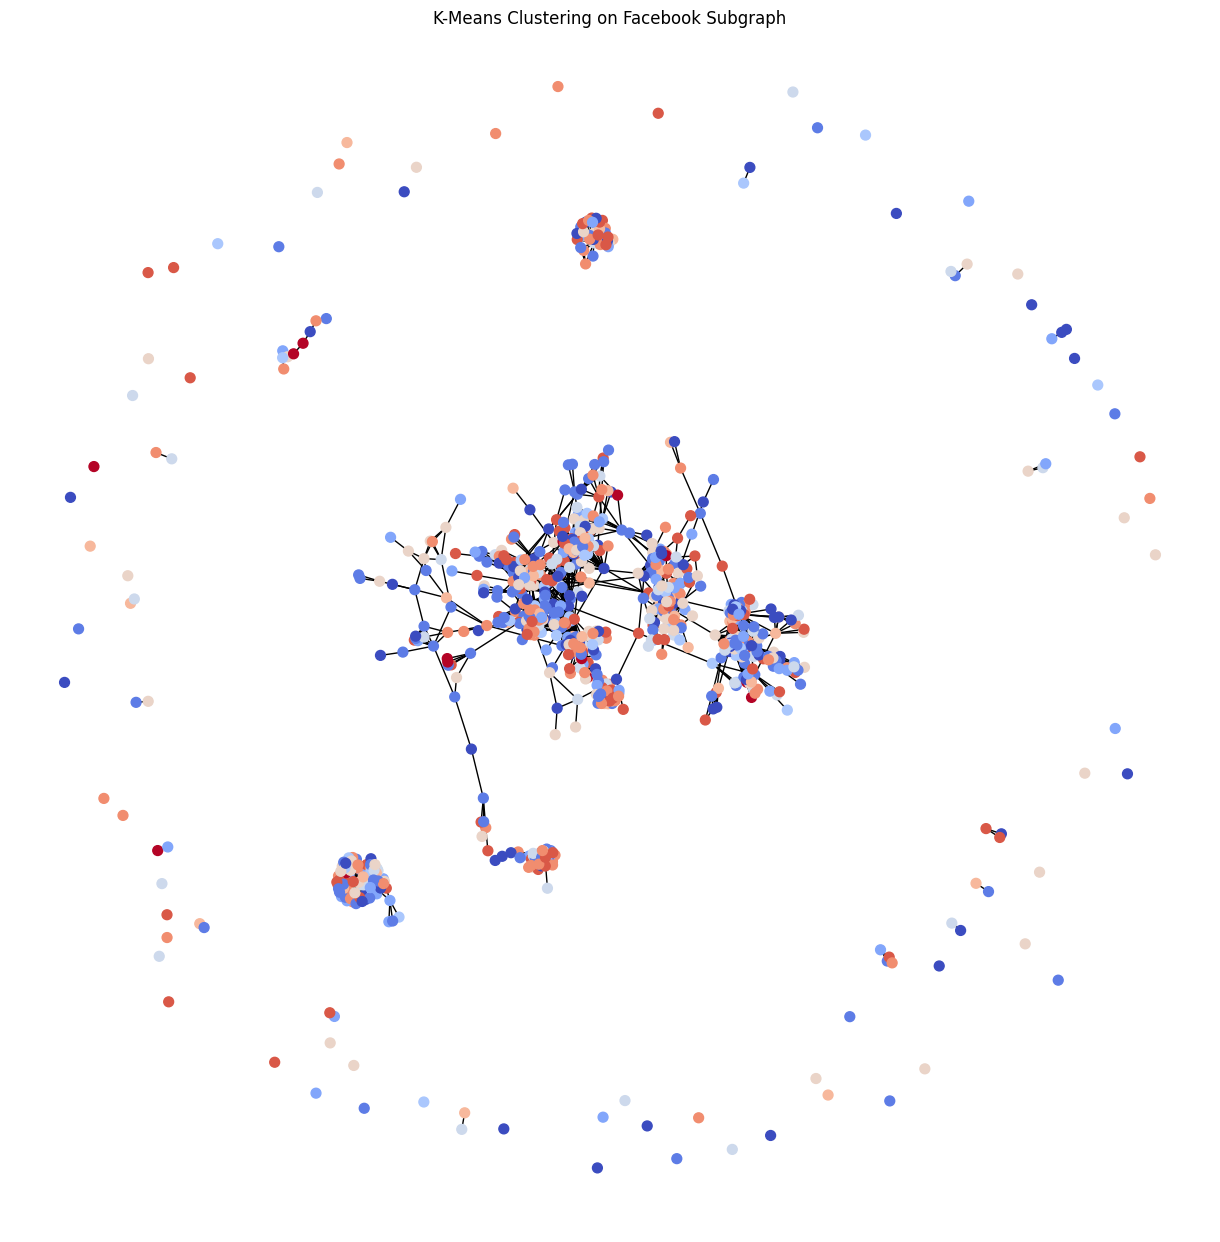

In [17]:
import matplotlib.pyplot as plt
import random

# Sample a subgraph
sampled_nodes = random.sample(G.nodes(), 1000)  # sample 1000 nodes
subG = G.subgraph(sampled_nodes)

# Get clusters for sampled nodes
sampled_kmeans_clusters = [kmeans_clusters[int(node)] for node in sampled_nodes]

# Visualize K-Means clusters on subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subG)
nx.draw(subG, pos, node_color=sampled_kmeans_clusters, cmap="coolwarm", node_size=50)
plt.title("K-Means Clustering on Facebook Subgraph")
plt.show()